(lgm1-notebook)=
# Curve di crescita latente 

## LGM e SEM

Nei termni del framework delle equazioni strutturali, il modello di crescita latente viene inteso come un modello a fattore comune vincolato, con variabili latenti per l’intercetta e la pendenza. Un tale modello a fattore comune vincolato, corrispondente al modello di crescita latente, può essere scritto nel modo seguente:

$$
\boldsymbol{y}_i = \boldsymbol{Λη}_i + \boldsymbol{u}_i,
$$

dove $\boldsymbol{y}_i$ è un vettore T × 1 dei punteggi osservati misurati ripetutamente per l’individuo $i$, dove T rappresenta il numero di valutazioni ripetute basate sulla metrica del tempo scelta, $\boldsymbol{Λ}$ è una matrice T × R di saturazioni fattoriali che definiscono i fattori di crescita (variabili latenti), dove R è il numero di fattori di crescita (R = 1 per il modello senza crescita, R = 2 per il modello di crescita lineare), $\boldsymbol{η}_i$ è un vettore R × 1 dei punteggi fattoriali per l’individuo $i$ e $\boldsymbol{u}_i$ è un vettore T × 1 dei punteggi residui o unici per l’individuo $i$.

I punteggi fattoriali possono essere scritti come deviazioni dalle medie a livello del campione, in modo tale che 

$$
\boldsymbol{η}_i = \boldsymbol{α} + \boldsymbol{xi},
$$

dove $\boldsymbol{α}$ è un vettore R × 1 delle medie dei fattori e $\boldsymbol{xi}$ è un vettore R × 1 delle deviazioni medie per per l’individuo $i$.

Il modello di crescita latente definito dalle due equazioni precedenti porta a una serie di previsioni sulla struttura delle medie e delle covarianze dei dati osservati. Queste previsioni del modello vengono utilizzate nel contesto della modellizzazione delle equazioni strutturali per calcolare le stime dei parametri e gli indici di adattamento del modello. La struttura delle media ($\boldsymbol{\mu}$) prevista dal modello di crescita latente è

$$
\boldsymbol{\mu} = \boldsymbol{\lambda} \boldsymbol{\alpha}.
$$

La struttura delle covarianze ($\boldsymbol{\Sigma}$) prevista dal modello di crescita latente è

$$
\boldsymbol{\Sigma} = \boldsymbol{\Lambda} \boldsymbol{\Psi} \boldsymbol{\Lambda}' +  \boldsymbol{\Theta}.
$$

Diversi tipi di modelli di crescita latente possono essere specificati cambiando le dimensioni e i valori contenuti nella matrice $\boldsymbol{Λ}$. Per il modello senza crescita, $\boldsymbol{Λ}$ è una matrice T × 1 (colonna) perché c’è solo una variabile latente nel modello senza crescita. Per il modello a crescita lineare, $\boldsymbol{Λ}$ è una matrice T × k, con k rilevazioni temporali, dove le saturazioni fattoriali sono fisse e uguali alla separazione temporale tra le rilevazioni.  Per esempio, con tre misurazioni temporali, le saturazioni fattoriali saranno specificate ai valori 0, 1, 2. Si noti che, in questo modo, si assume che tutte le unità di osservazione siano state misurate nella stessa occasione temporale.

## Una applicazione concreta

In questo tutorial esamineremo il modello di base LGM utilizzando un set di dati reali. 

In [4]:
source("_common.R")
library("lavaan")
library("semPlot")
library("knitr")
library("markdown")
library("patchwork")
library("psych")
library("DT")
library("kableExtra")
library("lme4")
set.seed(12345)

Considereremo il cambiamento nel rendimento in matematica dei bambini durante la scuola elementare e media utilizzando il set di dati NLSY-CYA [si veda {cite:p}`grimm2016growth`]. Iniziamo a leggere i dati.

In [5]:
#set filepath for data file
filepath <- "https://raw.githubusercontent.com/LRI-2/Data/main/GrowthModeling/nlsy_math_wide_R.dat"
# read in the text data file using the url() function
dat <- read.table(
  file = url(filepath),
  na.strings = "."
) # indicates the missing data designator
# copy data with new name
nlsy_math_wide <- dat

# Give the variable names
names(nlsy_math_wide) <- c(
  "id", "female", "lb_wght", "anti_k1",
  "math2", "math3", "math4", "math5", "math6", "math7", "math8",
  "age2", "age3", "age4", "age5", "age6", "age7", "age8",
  "men2", "men3", "men4", "men5", "men6", "men7", "men8",
  "spring2", "spring3", "spring4", "spring5", "spring6", "spring7", "spring8",
  "anti2", "anti3", "anti4", "anti5", "anti6", "anti7", "anti8"
)

# view the first few observations (and columns) in the data set
head(nlsy_math_wide[, 1:11], 10)

,id,female,lb_wght,anti_k1,math2,math3,math4,math5,math6,math7,math8
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,201,1,0,0,NA,38,NA,55,NA,NA,NA
2,303,1,0,1,26,NA,NA,33,NA,NA,NA
3,2702,0,0,0,56,NA,58,NA,NA,NA,80
4,4303,1,0,0,NA,41,58,NA,NA,NA,NA
5,5002,0,0,4,NA,NA,46,NA,54,NA,66
6,5005,1,0,0,35,NA,50,NA,60,NA,59
7,5701,0,0,2,NA,62,61,NA,NA,NA,NA
8,6102,0,0,0,NA,NA,55,67,NA,81,NA
9,6801,1,0,0,NA,54,NA,62,NA,66,NA


Il nostro interesse specifico riguarda il cambiamento relativo alle misure ripetute di matematica, da `math2` a `math8`.

Esaminiamo i dati.

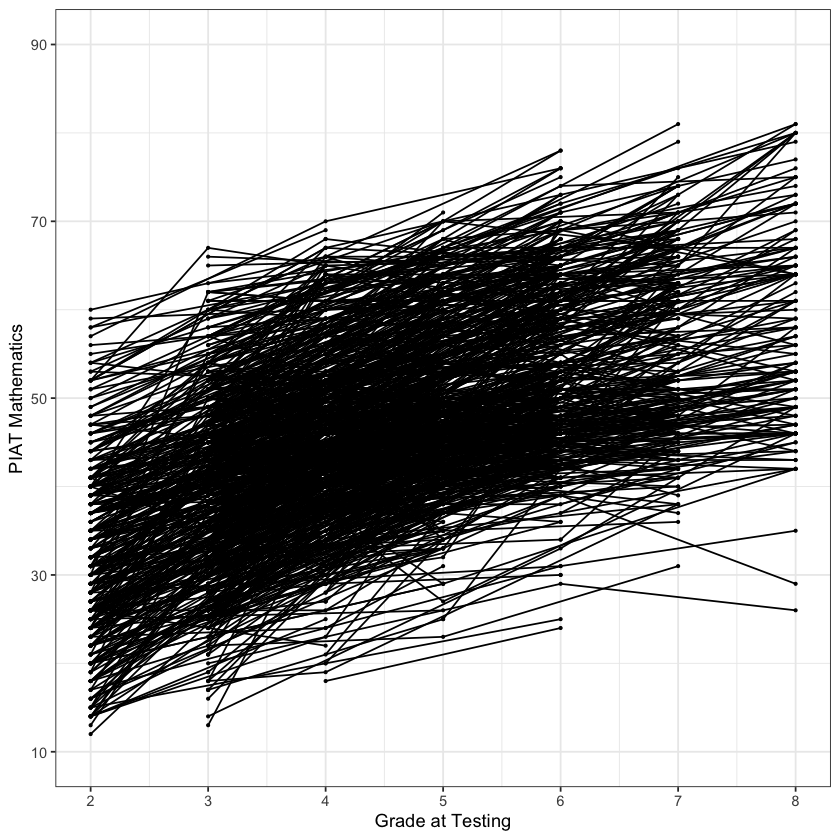

In [6]:
# subsetting to variables of interest
nlsy_math_sub <- nlsy_math_wide[, c(
  "id", "math2", "math3", "math4",
  "math5", "math6", "math7", "math8"
)]
# reshaping wide to long
nlsy_math_long <- reshape(
  data = nlsy_math_sub,
  timevar = c("grade"),
  idvar = "id",
  varying = c(
    "math2", "math3", "math4",
    "math5", "math6", "math7", "math8"
  ),
  direction = "long", sep = ""
)
# sorting for easy viewing
# order by id and time
nlsy_math_long <- nlsy_math_long[order(nlsy_math_long$id, nlsy_math_long$grade), ]
# remove rows with NA for math (needed to get trajoctory lines connected)
nlsy_math_long <- nlsy_math_long[which(is.na(nlsy_math_long$math) == FALSE), ]

# intraindividual change trajetories
ggplot(
  data = nlsy_math_long, # data set
  aes(x = grade, y = math, group = id)
) + # setting variables
  geom_point(size = .5) + # adding points to plot
  geom_line() + # adding lines to plot
  theme_bw() + # changing style/background
  # setting the x-axis with breaks and labels
  scale_x_continuous(
    limits = c(2, 8),
    breaks = c(2, 3, 4, 5, 6, 7, 8),
    name = "Grade at Testing"
  ) +
  # setting the y-axis with limits breaks and labels
  scale_y_continuous(
    limits = c(10, 90),
    breaks = c(10, 30, 50, 70, 90),
    name = "PIAT Mathematics"
  )

## Modello di assenza di crescita

Sembra esserci una crescita sistematica nei punteggi di matematica nel tempo, come si può vedere nel nostro grafico sopra. Per iniziare l’analisi adatteremo un modello senza crescita. Questo modello senza crescita agirà come il nostro modello “nullo” a cui confrontare i modelli successivi.

Presentiamo il modello senza crescita perché è un punto di partenza comune e logico per qualsiasi studio del cambiamento poiché questo modello prevede che i punteggi non cambino con l’aumentare del tempo. Pertanto, il modello senza crescita è un modello che spesso vogliamo respingere. Il modello senza crescita ha una variabile latente, un’intercetta, che rappresenta il livello complessivo di prestazione nel tempo.

Impostiamo il modello senza crescita con la sintassi di lavaan.

In [8]:
#writing out no growth model in full SEM way 
ng_math_lavaan_model <- ' 
  # latent variable definitions
      #intercept
      eta_1 =~ 1*math2
      eta_1 =~ 1*math3
      eta_1 =~ 1*math4
      eta_1 =~ 1*math5
      eta_1 =~ 1*math6
      eta_1 =~ 1*math7
      eta_1 =~ 1*math8

  # factor variances
      eta_1 ~~ eta_1

  # covariances among factors 
      #none (only 1 factor)

  # factor means 
      eta_1 ~ start(30)*1

  # manifest variances (made equivalent by naming theta)
      math2 ~~ theta*math2
      math3 ~~ theta*math3
      math4 ~~ theta*math4
      math5 ~~ theta*math5
      math6 ~~ theta*math6
      math7 ~~ theta*math7
      math8 ~~ theta*math8
  # manifest means (fixed at zero)
      math2 ~ 0*1
      math3 ~ 0*1
      math4 ~ 0*1
      math5 ~ 0*1
      math6 ~ 0*1
      math7 ~ 0*1
      math8 ~ 0*1
' #end of model definition

Adattiamo il modello ai dati.

In [9]:
ng_math_lavaan_fit <- sem(ng_math_lavaan_model,
  data = nlsy_math_wide,
  meanstructure = TRUE,
  estimator = "ML",
  missing = "fiml"
)

Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING: some cases are empty and will be ignored:
  741”
Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING:
    due to missing values, some pairwise combinations have less than
    10% coverage; use lavInspect(fit, "coverage") to investigate.”
Warning message in lav_mvnorm_missing_h1_estimate_moments(Y = X[[g]], wt = WT[[g]], :
“lavaan WARNING:
    Maximum number of iterations reached when computing the sample
    moments using EM; use the em.h1.iter.max= argument to increase the
    number of iterations”


Esaminiamo la soluzione.

In [21]:
out = summary(ng_math_lavaan_fit, fit.measures=TRUE)
print(out)

lavaan 0.6.15 ended normally after 18 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                         9
  Number of equality constraints                     6

                                                  Used       Total
  Number of observations                           932         933
  Number of missing patterns                        60            

Model Test User Model:
                                                      
  Test statistic                              1759.002
  Degrees of freedom                                32
  P-value (Chi-square)                           0.000

Model Test Baseline Model:

  Test statistic                               862.334
  Degrees of freedom                                21
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.000

Otteniamo il diagramma di percorso.

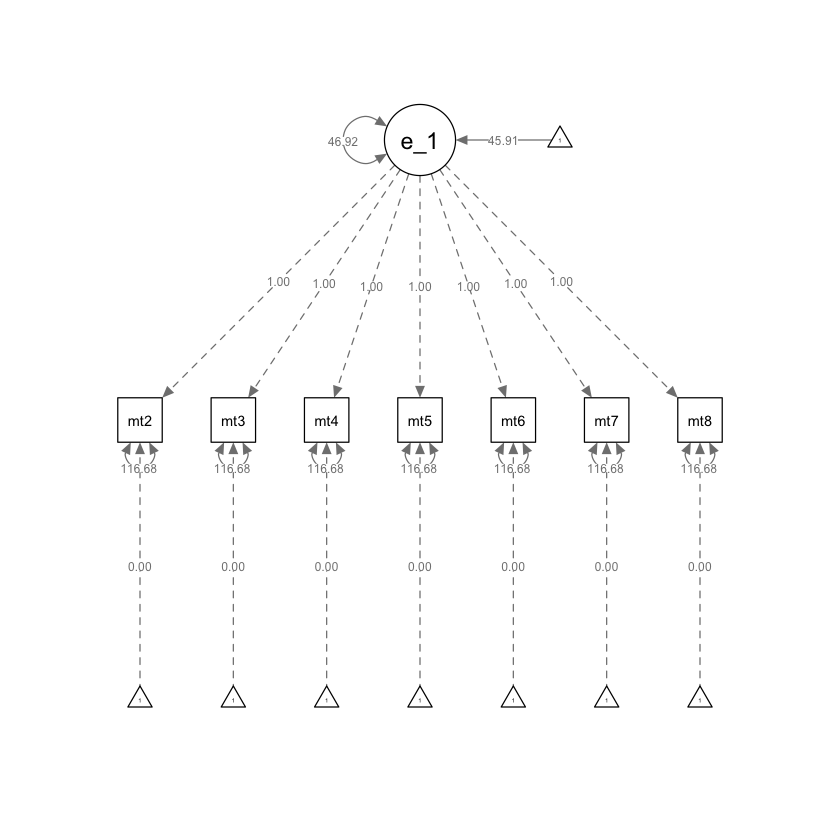

In [11]:
semPaths(ng_math_lavaan_fit,what = "path", whatLabels = "par")

Calcoliamo le traiettorie predette.

In [12]:
#obtaining predicted factor scores for individuals
nlsy_math_predicted <- as.data.frame(cbind(nlsy_math_wide$id,lavPredict(ng_math_lavaan_fit)))

#naming columns
names(nlsy_math_predicted) <- c("id", "eta_1")

#looking at data
head(nlsy_math_predicted) 

,id,eta_1
,<dbl>,<dbl>
1,201,46.17558
2,303,38.59816
3,2702,56.16725
4,4303,47.51278
5,5002,51.06429
6,5005,49.05038


Warning message:
“Removed 7 rows containing missing values (`geom_line()`).”


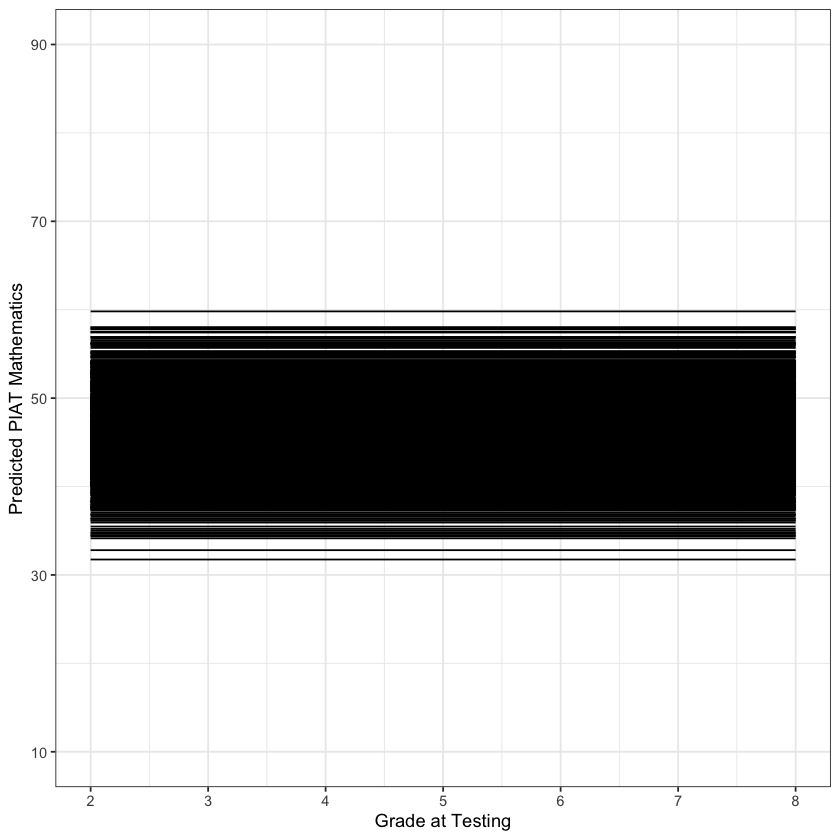

In [14]:
#calculating implied manifest scores
nlsy_math_predicted$math2 <- 1 * nlsy_math_predicted$eta_1
nlsy_math_predicted$math3 <- 1 * nlsy_math_predicted$eta_1
nlsy_math_predicted$math4 <- 1 * nlsy_math_predicted$eta_1
nlsy_math_predicted$math5 <- 1 * nlsy_math_predicted$eta_1
nlsy_math_predicted$math6 <- 1 * nlsy_math_predicted$eta_1
nlsy_math_predicted$math7 <- 1 * nlsy_math_predicted$eta_1
nlsy_math_predicted$math8 <- 1 * nlsy_math_predicted$eta_1

# reshaping wide to long
nlsy_math_predicted_long <- reshape(
  data = nlsy_math_predicted,
  timevar = c("grade"),
  idvar = "id",
  varying = c(
    "math2", "math3", "math4",
    "math5", "math6", "math7", "math8"
  ),
  direction = "long", sep = ""
)
# sorting for easy viewing
# order by id and time
nlsy_math_predicted_long <- nlsy_math_predicted_long[order(nlsy_math_predicted_long$id, nlsy_math_predicted_long$grade), ]

# intraindividual change trajetories
ggplot(
  data = nlsy_math_predicted_long, # data set
  aes(x = grade, y = math, group = id)
) + # setting variables
  # geom_point(size=.5) + #adding points to plot
  geom_line() + # adding lines to plot
  theme_bw() + # changing style/background
  # setting the x-axis with breaks and labels
  scale_x_continuous(
    limits = c(2, 8),
    breaks = c(2, 3, 4, 5, 6, 7, 8),
    name = "Grade at Testing"
  ) +
  # setting the y-axis with limits breaks and labels
  scale_y_continuous(
    limits = c(10, 90),
    breaks = c(10, 30, 50, 70, 90),
    name = "Predicted PIAT Mathematics"
  )

Vediamo dal grafico che il modello, come richiesto, produce una traiettoria di crescita piatta per ciascun individuo.

## Modello di crescita lineare

Nella discussione dei modelli di crescita, dopo il modello di assenza di crescita, si esamina sempre il modello di crescita lineare a causa della sua semplicità. Inoltre, i modelli di crescita lineare sono spesso un punto di partenza quando si cerca di comprendere il cambiamento all’interno della persona.

Implementiamo dunque un modello di crescita latente lineare.

In [15]:
lg_math_lavaan_model <- '
  # latent variable definitions
      #intercept (note intercept is a reserved term)
      eta_1 =~ 1*math2
      eta_1 =~ 1*math3
      eta_1 =~ 1*math4
      eta_1 =~ 1*math5
      eta_1 =~ 1*math6
      eta_1 =~ 1*math7
      eta_1 =~ 1*math8

      #linear slope 
      eta_2 =~ 0*math2
      eta_2 =~ 1*math3
      eta_2 =~ 2*math4
      eta_2 =~ 3*math5
      eta_2 =~ 4*math6
      eta_2 =~ 5*math7
      eta_2 =~ 6*math8

  # factor variances
      eta_1 ~~ eta_1
      eta_2 ~~ eta_2

  # covariances among factors 
      eta_1 ~~ eta_2

  # factor means 
      eta_1 ~ start(35)*1
      eta_2 ~ start(4)*1

  # manifest variances (made equivalent by naming theta)
      math2 ~~ theta*math2
      math3 ~~ theta*math3
      math4 ~~ theta*math4
      math5 ~~ theta*math5
      math6 ~~ theta*math6
      math7 ~~ theta*math7
      math8 ~~ theta*math8
  # manifest means (fixed at zero)
      math2 ~ 0*1
      math3 ~ 0*1
      math4 ~ 0*1
      math5 ~ 0*1
      math6 ~ 0*1
      math7 ~ 0*1
      math8 ~ 0*1
' #end of model definition

Adattiamo il modello ai dati.

In [16]:
lg_math_lavaan_fit <- sem(lg_math_lavaan_model,
  data = nlsy_math_wide,
  meanstructure = TRUE,
  estimator = "ML",
  missing = "fiml"
)

Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING: some cases are empty and will be ignored:
  741”
Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING:
    due to missing values, some pairwise combinations have less than
    10% coverage; use lavInspect(fit, "coverage") to investigate.”
Warning message in lav_mvnorm_missing_h1_estimate_moments(Y = X[[g]], wt = WT[[g]], :
“lavaan WARNING:
    Maximum number of iterations reached when computing the sample
    moments using EM; use the em.h1.iter.max= argument to increase the
    number of iterations”


Esaminiamo il risultato ottenuto.

In [22]:
out = summary(lg_math_lavaan_fit, fit.measures = TRUE)
print(out)

lavaan 0.6.15 ended normally after 27 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        12
  Number of equality constraints                     6

                                                  Used       Total
  Number of observations                           932         933
  Number of missing patterns                        60            

Model Test User Model:
                                                      
  Test statistic                               204.484
  Degrees of freedom                                29
  P-value (Chi-square)                           0.000

Model Test Baseline Model:

  Test statistic                               862.334
  Degrees of freedom                                21
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.791

Generiamo un diagramma di percorso.

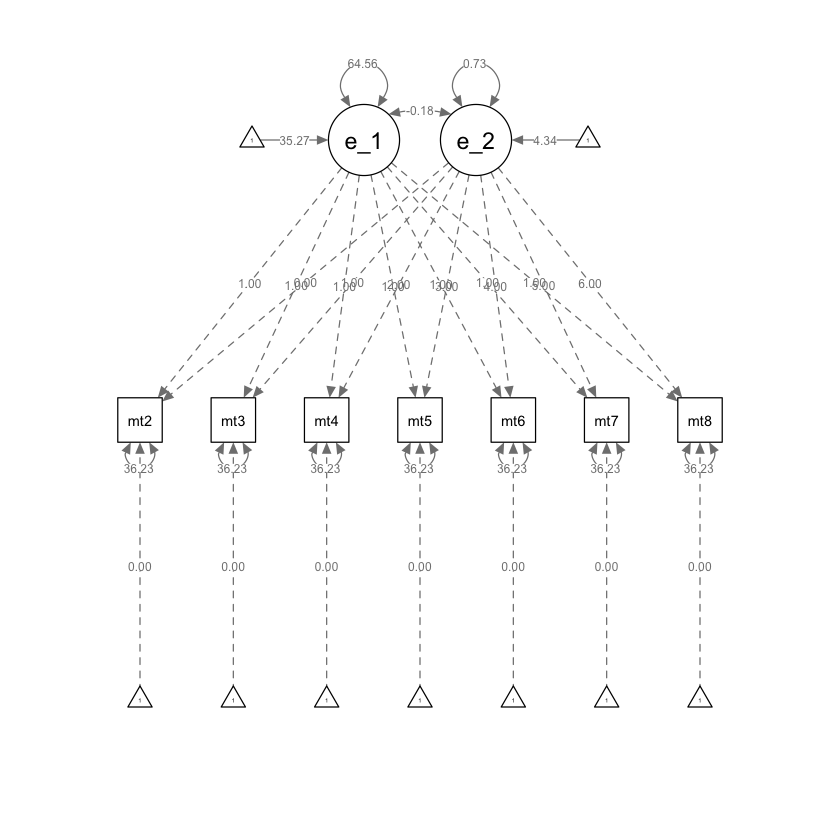

In [18]:
semPaths(lg_math_lavaan_fit,what = "path", whatLabels = "par")

Esaminiamo le traiettorie di crescita.

In [19]:
nlsy_math_predicted <- as.data.frame(cbind(nlsy_math_wide$id,lavPredict(lg_math_lavaan_fit)))

#naming columns
names(nlsy_math_predicted) <- c("id", "eta_1", "eta_2")

head(nlsy_math_predicted)

,id,eta_1,eta_2
,<dbl>,<dbl>,<dbl>
1,201,36.94675,4.534084
2,303,26.03589,4.050780
3,2702,49.70187,4.594148
4,4303,41.04200,4.548063
5,5002,37.01241,4.496745
6,5005,37.68809,4.324197


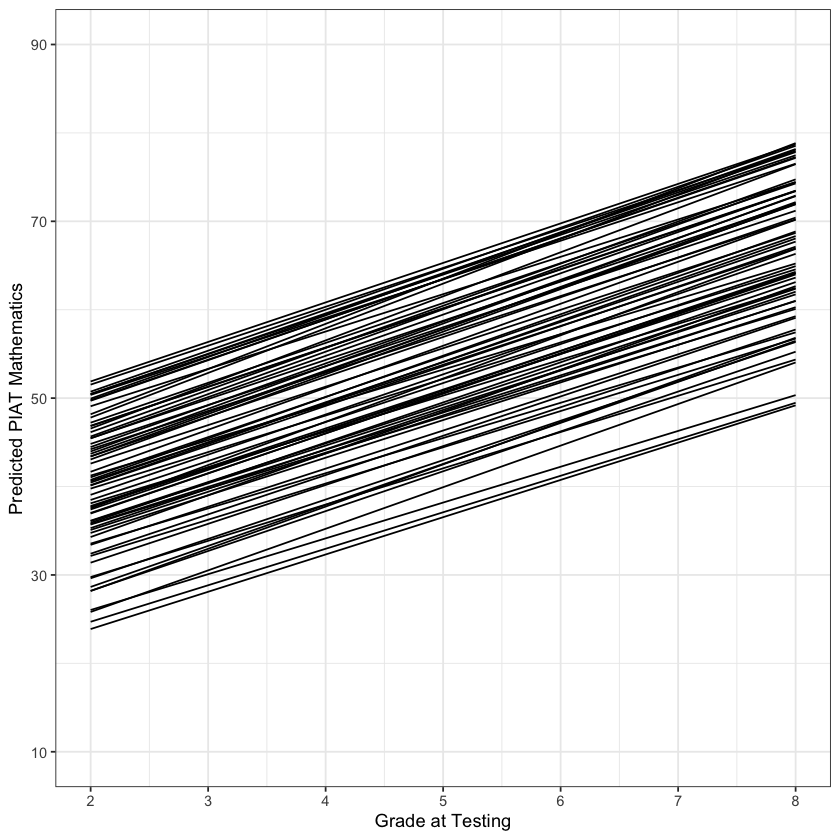

In [20]:
#calculating implied manifest scores
nlsy_math_predicted$math2 <- 1 * nlsy_math_predicted$eta_1 + 0 * nlsy_math_predicted$eta_2
nlsy_math_predicted$math3 <- 1 * nlsy_math_predicted$eta_1 + 1 * nlsy_math_predicted$eta_2
nlsy_math_predicted$math4 <- 1 * nlsy_math_predicted$eta_1 + 2 * nlsy_math_predicted$eta_2
nlsy_math_predicted$math5 <- 1 * nlsy_math_predicted$eta_1 + 3 * nlsy_math_predicted$eta_2
nlsy_math_predicted$math6 <- 1 * nlsy_math_predicted$eta_1 + 4 * nlsy_math_predicted$eta_2
nlsy_math_predicted$math7 <- 1 * nlsy_math_predicted$eta_1 + 5 * nlsy_math_predicted$eta_2
nlsy_math_predicted$math8 <- 1 * nlsy_math_predicted$eta_1 + 6 * nlsy_math_predicted$eta_2

# reshaping wide to long
nlsy_math_predicted_long <- reshape(
  data = nlsy_math_predicted,
  timevar = c("grade"),
  idvar = "id",
  varying = c(
    "math2", "math3", "math4",
    "math5", "math6", "math7", "math8"
  ),
  direction = "long", sep = ""
)
# sorting for easy viewing
# order by id and time
nlsy_math_predicted_long <- nlsy_math_predicted_long[order(nlsy_math_predicted_long$id, nlsy_math_predicted_long$grade), ]

# intraindividual change trajetories
ggplot(
  data = nlsy_math_predicted_long[which(nlsy_math_predicted_long$id < 80000), ], # data set
  aes(x = grade, y = math, group = id)
) + # setting variables
  # geom_point(size=.5) + #adding points to plot
  geom_line() + # adding lines to plot
  theme_bw() + # changing style/background
  # setting the x-axis with breaks and labels
  scale_x_continuous(
    limits = c(2, 8),
    breaks = c(2, 3, 4, 5, 6, 7, 8),
    name = "Grade at Testing"
  ) +
  # setting the y-axis with limits breaks and labels
  scale_y_continuous(
    limits = c(10, 90),
    breaks = c(10, 30, 50, 70, 90),
    name = "Predicted PIAT Mathematics"
  )

Dal grafico si può notare che questo modello rappresenta la traiettoria di ogni bambino come una linea retta, con alcune differenze interindividuali nella velocità del cambiamento intraindividuale. Questo tutorial ha dunque illustrato come impostare e adattare modelli di crescita lineare nel framework di modellizzazione SEM utilizzando il pacchetto lavaan in R, nonché come calcolare e rappresentare graficamente le traiettorie di crescita previste dal modello.

## Considerazioni conclusive

I modelli di crescita lineare sono un punto di partenza appropriato per qualsiasi studio sul cambiamento individuale. In molti casi, questi modelli sono in grado di catturare bene il processo di cambiamento osservato; tuttavia, ci sono numerose volte in cui questo non è il caso. Pertanto, è sempre utile adattare e confrontare modelli aggiuntivi e considerare le differenze di gruppo nel cambiamento. Come abbiamo notato, l'adattamento dei modelli di crescita nei framework di modellizzazione multilivello e delle equazioni strutturali ha vantaggi e limitazioni, e uno dei vantaggi del framework delle equazioni strutturali è evidente in questo tutorial poiché sono disponibili gli indici di adattamento globale per valutare l'adattamento del modello ai dati osservati (ad esempio, utilizzando RMSEA, CFI e TLI), mentre l'approccio dei modelli misti può usare solo gli indici AIC e BIC e le diagnostiche del modello (ad esempio, grafico dei residui). 

Indipendentemente dal framework utilizzato per adattare i modelli di crescita lineare, ci sono alcune considerazioni importanti da tenere a mente. La prima è la metrica del tempo. Nell’esempio attuale, abbiamo utilizzato il grado al momento del test come metrica del tempo, ma ovviamente sono possibili altre metriche. In particolare, l’età al momento del test potrebbe essere più rilevante, poiché questa metrica del tempo può catturare meglio lo spazio tra le valutazioni. Inoltre, potrebbero esserci alcune limitazioni nell’utilizzo del grado, come gli studenti che ripetono o saltano un grado. Pertanto, gli anni trascorsi dalla seconda elementare potrebbero essere una metrica del tempo più appropriata.

Una terza considerazione riguarda la posizione dell’intercetta. Nel nostro esempio illustrativo, l’intercetta era centrata sulla valutazione della seconda elementare perché questa era l’occasione di misurazione più precoce e gli studiosi sono spesso interessati alle differenze individuali in un punto iniziale nel tempo. L’intercetta potrebbe essere posizionata in qualsiasi punto temporale, ma scegliere un punto temporale rilevante, uno con dati osservati e con significato al di fuori dello studio specifico, è l’ideale. Ad esempio, centrare un’intercetta alla fine dell’ottava elementare potrebbe essere importante con i dati di matematica se fossimo interessati alla preparazione per la scuola superiore.



